In [1]:
import numpy as np
import tensorflow as tf
import requests
import uuid

In [2]:
class ESNCell(tf.contrib.rnn.RNNCell):
    """
    Echo State Network Cell.

    Based on http://www.faculty.jacobs-university.de/hjaeger/pubs/EchoStatesTechRep.pdf
    Only the reservoir, the randomized recurrent layer, is modelled. The readout trainable layer
    which map reservoir output to the target output is not implemented by this cell,
    thus neither are feedback from readout to the reservoir (a quite common technique).

    Here a practical guide to use Echo State Networks:
    http://minds.jacobs-university.de/sites/default/files/uploads/papers/PracticalESN.pdf

    Since at the moment TF doesn't provide a way to compute spectral radius
    of a matrix the echo state property necessary condition `max(eig(W)) < 1` is approximated
    scaling the norm 2 of the reservoir matrix which is an upper bound of the spectral radius.
    See https://en.wikipedia.org/wiki/Matrix_norm, the section on induced norms.

    """

    def __init__(self, num_units, wr2_scale=0.7, connectivity=0.1, leaky=1.0, activation=tf.tanh,
               win_init=tf.random_normal_initializer(),
               wr_init=tf.random_normal_initializer(),
               bias_init=tf.random_normal_initializer()):
        """Initialize the Echo State Network Cell.

        Args:
          num_units: Int or 0-D Int Tensor, the number of units in the reservoir
          wr2_scale: desired norm2 of reservoir weight matrix.
            `wr2_scale < 1` is a sufficient condition for echo state property.
          connectivity: connection probability between two reservoir units
          leaky: leaky parameter
          activation: activation function
          win_init: initializer for input weights
          wr_init: used to initialize reservoir weights before applying connectivity mask and scaling
          bias_init: initializer for biases
        """
        self._num_units = num_units
        self._leaky = leaky
        self._activation = activation
        self._uuid = str(uuid.uuid1())

        def _wr_initializer(shape, dtype, partition_info=None):
            wr = wr_init(shape, dtype=dtype)

            connectivity_mask = tf.cast(
              tf.less_equal(
                tf.random_uniform(shape),
                connectivity),
            dtype)


            wr = tf.multiply(wr, connectivity_mask)
            
            wr_norm2 = tf.sqrt(tf.reduce_sum(tf.square(wr)))

            is_norm_0 = tf.cast(tf.equal(wr_norm2, 0), dtype)

            wr = wr * wr2_scale / (wr_norm2 + 1 * is_norm_0)

            return wr

        self._win_initializer = win_init
        self._bias_initializer = bias_init
        self._wr_initializer = _wr_initializer

    @property
    def output_size(self):
        return self._num_units

    @property
    def state_size(self):
        return self._num_units

    def __call__(self, inputs, state, scope=None):
        """ Run one step of ESN Cell

        Args:
          inputs: `2-D Tensor` with shape `[batch_size x input_size]`.
          state: `2-D Tensor` with shape `[batch_size x self.state_size]`.
          scope: VariableScope for the created subgraph; defaults to class `ESNCell`.

        Returns:
          A tuple `(output, new_state)`, computed as
          `output = new_state = (1 - leaky) * state + leaky * activation(Win * input + Wr * state + B)`.

        Raises:
          ValueError: if `inputs` or `state` tensor size mismatch the previously provided dimension.
        """

        inputs = tf.convert_to_tensor(inputs)
        input_size = inputs .get_shape().as_list()[1]
        dtype = inputs.dtype

        with tf.variable_scope(scope or type(self).__name__+self._uuid):  # "ESNCell"
            win = tf.get_variable("InputMatrix", [input_size, self._num_units], dtype=dtype,
                            trainable=False, initializer=self._win_initializer)
            wr = tf.get_variable("ReservoirMatrix", [self._num_units, self._num_units], dtype=dtype,
                           trainable=False, initializer=self._wr_initializer)
            b = tf.get_variable("Bias", [self._num_units], dtype=dtype, trainable=False, initializer=self._bias_initializer)
        
        in_mat = tf.concat([inputs, state],1)
        weights_mat = tf.concat([win, wr],0)
        output = (1 - self._leaky) * state + self._leaky * self._activation(tf.matmul(in_mat, weights_mat) + b)

        return output, output

Fetching data...


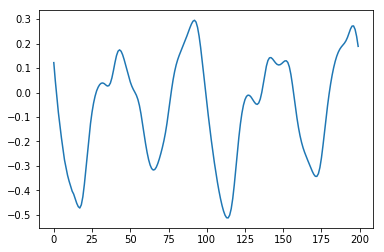

In [12]:
tr_size=500
washout_size=50
units=100
connectivity=0.1
scale=0.7
elements=10000


logs_path = "test"

print("Fetching data...")
data_str = requests.get('http://minds.jacobs-university.de/sites/default/files/uploads/mantas/code/MackeyGlass_t17.txt').content

data = list(map(float, data_str.splitlines()[:elements]))
data_t = tf.reshape(tf.constant(data), [1, elements, 1])
esn = ESNCell(units, connectivity, scale)

print("Building graph...")
outputs, final_state = tf.nn.dynamic_rnn(esn, data_t, dtype=tf.float32)
washed = tf.squeeze(tf.slice(outputs, [0, washout_size, 0], [-1, -1, -1]))

with tf.Session() as S:
    writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    S.run(tf.initialize_all_variables())

    print("Computing embeddings...")
    res = S.run(washed)

    print("Computing direct solution...")
    state = np.array(res)
    tr_state = np.mat(state[:tr_size])
    ts_state = np.mat(state[tr_size:])
    wout = np.transpose(np.mat(data[washout_size+1:tr_size+washout_size+1]) * np.transpose(np.linalg.pinv(tr_state)))

    print("Testing performance...")
    ts_out = np.mat((np.transpose(ts_state * wout).tolist())[0][:-1])
    ts_y = np.mat(data[washout_size+tr_size+1:])

    ts_mse = np.mean(np.square(ts_y - ts_out))
    
    writer.flush()
    writer.close()
print("Test MSE: " + str(ts_mse))